In [5]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import adjusted_rand_score
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

In [6]:
m = ["roary","panacota","peppan","pirate","panaroo","panta","panX","panXX"]
c = list(plt.get_cmap("Set2").colors[:8])
c2 = list(plt.get_cmap("Pastel2").colors[:8])
colors=dict(zip(m,c))
colors2=dict(zip(m,c2))

In [7]:
def get_hash(locus_list):
    locus_list.sort()
    return hash(frozenset(locus_list))

def get_idx(locus_list):
    if any("PEPPAN" in l for l in locus_list):
        return True
    else:
        return False

def flatten(xss):
    return [x for xs in xss for x in xs]

def get_id(tag,locus2id):
    return locus2id.get(tag)

In [8]:
organism="SimPan"
ref_path="/scicore/home/neher/GROUP/data/2024_panXX_bench/SimPan-15"
DATASETS = ["70_50","80_50","90_50","90_60","90_80"]
n_genomes = 50
METHODS = ["roary","panacota","peppan","panaroo","panta","panX","panXX"]

In [5]:
false_splits = {}
false_merges = {}
out_df = pd.DataFrame(columns=["ARI","method","dataset"])

for dataset in DATASETS:
    print(f"Loading dataset: {dataset}")
    with open(f"{ref_path}/{dataset}/locus2id.json") as fh:
        locus2id  = json.load(fh)
    ref_df = pd.read_json(f"{ref_path}/{dataset}/{dataset}-reference.json",dtype=False)[["locus"]].rename(columns={"locus":"tag"})
    ref_df["true_label"] = ref_df.index
    
    labels = ref_df.explode("tag")
    labels["locus"] = labels["tag"].apply(get_id,locus2id=locus2id)
    labels = labels.sort_values("locus")[["locus","true_label"]]
    labels = labels.reset_index(drop="index")

    num_false_merges = []

    for method in METHODS:
        if (dataset == "90_80") and (method == "panX"):
            #set every value to 0
            out_df.loc[len(out_df)] = [1,method,dataset]
            num_false_merges.append(0)
            labels[method] = labels["true_label"]
            continue

        method_df = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")[["geneId","locus"]].explode("locus",ignore_index=True)

        missing_loci = set(labels["locus"]).difference(set(method_df["locus"]))
        print(f"Missing loci: {len(missing_loci)}")

        m_label = -1
        for m_locus in missing_loci:
            method_df.loc[len(method_df)]=[m_label,m_locus]
            m_label-=1


        method_df.sort_values("locus",inplace=True)
        method_df.reset_index(inplace=True,drop="index")
        labels[method] = method_df["geneId"]
        print(f"{method} is done!")

        out_df.loc[len(out_df)] = [adjusted_rand_score(labels["true_label"],labels[method]),method,dataset]


        # for false splits/merges
        total = labels[[method,"true_label"]].groupby(by=method).agg(lambda x:len(set(x)))
        expected_num_clusters = len(total)
        num_false_merges.append(-1* int(total.sum().true_label-expected_num_clusters))


    # for false splits/merges
    grouped = labels.drop(columns="locus").groupby(by="true_label").agg(lambda x:len(set(x))).reset_index()
    expected_num_clusters = len(grouped)
    num_false_splits = grouped.drop(columns="true_label").apply(lambda x:sum(x)-expected_num_clusters).values.tolist()    
    false_merges[dataset] = num_false_merges
    false_splits[dataset] = num_false_splits

print("\nFinished!")

Loading dataset: 70_50
Missing loci: 6
roary is done!
Missing loci: 0
panacota is done!
Missing loci: 719
peppan is done!
Missing loci: 3
panaroo is done!
Missing loci: 729
panta is done!
Missing loci: 13
panX is done!
Missing loci: 0
panXX is done!
Loading dataset: 80_50
Missing loci: 0
roary is done!
Missing loci: 0
panacota is done!
Missing loci: 284
peppan is done!
Missing loci: 0
panaroo is done!
Missing loci: 403
panta is done!
Missing loci: 0
panX is done!
Missing loci: 0
panXX is done!
Loading dataset: 90_50
Missing loci: 3
roary is done!
Missing loci: 0
panacota is done!
Missing loci: 52
peppan is done!
Missing loci: 2
panaroo is done!
Missing loci: 114
panta is done!
Missing loci: 3
panX is done!
Missing loci: 0
panXX is done!
Loading dataset: 90_60
Missing loci: 0
roary is done!
Missing loci: 0
panacota is done!
Missing loci: 83
peppan is done!
Missing loci: 0
panaroo is done!
Missing loci: 137
panta is done!
Missing loci: 0
panX is done!
Missing loci: 0
panXX is done!
Loadi

In [6]:
out_df["1-ARI"] = 1-out_df["ARI"]

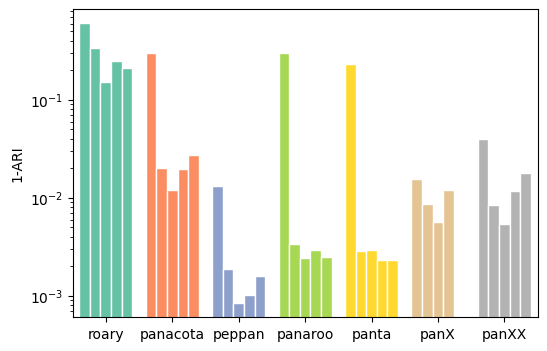

In [8]:
x = METHODS

fig,ax = plt.subplots(1,1,figsize=(6,4))

c = [colors[method] for method in METHODS]*5

bars = sns.barplot(data=out_df,x="method",y="1-ARI",hue="dataset",width=0.8)

for i,b in enumerate(filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), bars.get_children())):
    h = b.get_height()
    if h not in (0,1):
        b.set_color(c[i])
        b.set_edgecolor("w")

ax.set_yscale("log")
ax.set_xlabel(None)
ax.legend().remove()

fig.savefig("sim-ari-formatted.png",dpi=300)

plt.show()

/scratch/ipykernel_2881774/3124410121.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(abs(ax.get_yticks()).astype(int))


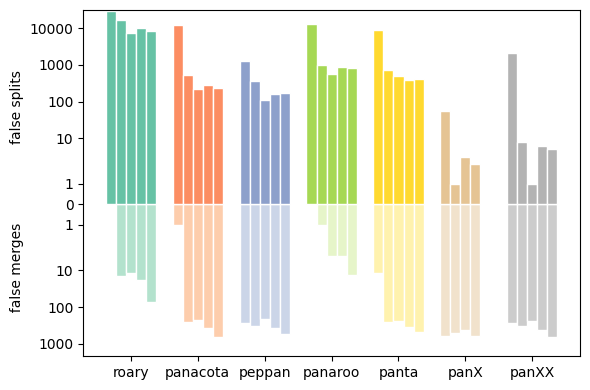

In [11]:
l = np.arange(len(METHODS))
width = 0.15

c = [colors[method] for method in METHODS]*5
c2 = [colors2[method] for method in METHODS]*5

fig,ax = plt.subplots(figsize=(6,4))

# plot and set colors
multiplier = 0
for dataset, ari in false_merges.items():
    offset = width*multiplier
    rects = ax.bar(l + offset, ari, width, label=dataset)
    for i,r in enumerate(rects.patches):
        r.set_edgecolor("w")
        r.set_facecolor(colors2[METHODS[i]])
    multiplier += 1

# plot and set colors
multiplier = 0
for dataset, ari in false_splits.items():
    offset = width*multiplier
    rects = ax.bar(l + offset, ari, width, label=dataset)
    for i,r in enumerate(rects.patches):
        r.set_edgecolor("w")
        r.set_facecolor(colors[METHODS[i]])
    multiplier += 1

ax.set_xticks(l + 2*width, METHODS)
ax.set_yscale("symlog")
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(abs(ax.get_yticks()).astype(int))

ax.set_ylabel("          false merges                  false splits",loc="bottom")
fig.tight_layout()

fig.savefig("sim-false-splits-merges-formatted.png",dpi=300)
plt.show()

/scratch/ipykernel_2881774/1479173396.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(abs(ax.get_yticks().astype(int)))


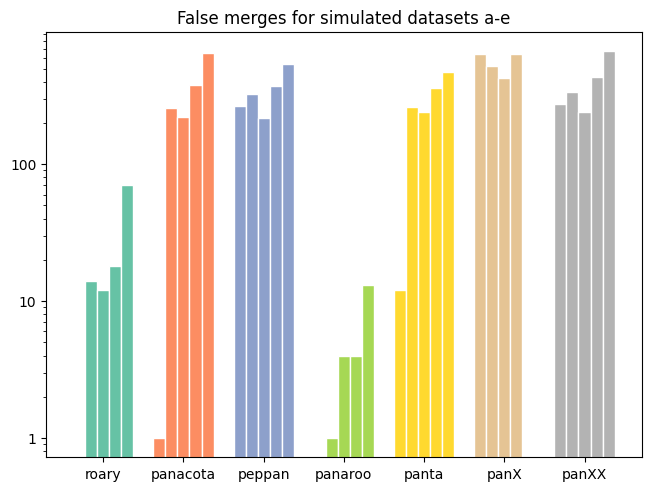

In [12]:
l = np.arange(len(METHODS))
width = 0.15

c = [colors[method] for method in METHODS]*5
c2 = [colors2[method] for method in METHODS]*5

fig,ax = plt.subplots(layout="constrained")

# plot and set colors
multiplier = 0
for dataset, fmn in false_merges.items():
    offset = width*multiplier
    fm = [abs(f) for f in fmn]
    rects = ax.bar(l + offset, fm, width, label=dataset)
    for i,r in enumerate(rects.patches):
        r.set_edgecolor("w")
        r.set_facecolor(colors[METHODS[i]])
    multiplier += 1


ax.set_title('False merges for simulated datasets a-e')
ax.set_xticks(l + 2*width, METHODS)
ax.set_yscale("log")
ax.set_yticklabels(abs(ax.get_yticks().astype(int)))

plt.show()


/scratch/ipykernel_2881774/1411390757.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(abs(ax.get_yticks().astype(int)))


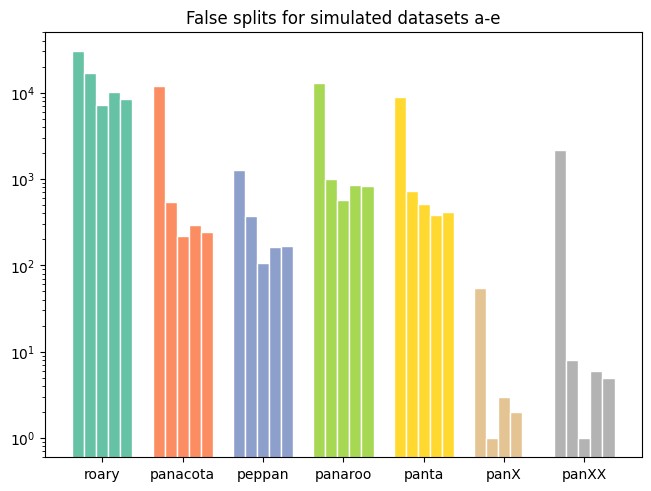

In [13]:
l = np.arange(len(METHODS))
width = 0.15

c = [colors[method] for method in METHODS]*5
c2 = [colors2[method] for method in METHODS]*5

fig,ax = plt.subplots(layout="constrained")

# plot and set colors
multiplier = 0
for dataset, fs in false_splits.items():
    offset = width*multiplier
    rects = ax.bar(l + offset, fs, width, label=dataset)
    for i,r in enumerate(rects.patches):
        r.set_edgecolor("w")
        r.set_facecolor(colors[METHODS[i]])
    multiplier += 1

ax.set_title('False splits for simulated datasets a-e')
ax.set_xticks(l + 2*width, METHODS)
ax.set_yticklabels(abs(ax.get_yticks().astype(int)))

ax.set_yscale("log")

plt.show()

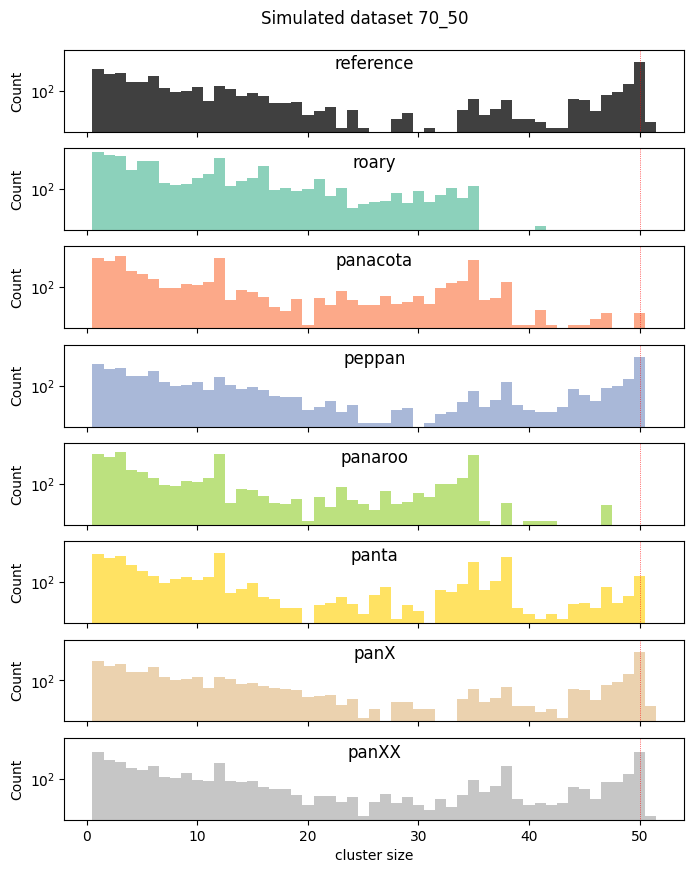

In [14]:
#------------------------------------------#
#        plot count distribution 
#         for SimPan dataset
#------------------------------------------#
organism = "SimPan"
dataset="70_50"

fig,axes = plt.subplots(ncols=1,nrows=len(METHODS)+1,sharex=True,sharey=True,figsize=(8,10))

MAX=51
i=0

counts = pd.read_json(f"{ref_path}/{dataset}/{dataset}-reference.json",dtype=False)["count"]
#ignore clusters above n_genomes + 5
c = counts[(counts>0)&(counts<=MAX)]
ax = axes[i]
sns.histplot(data=c,color="black",edgecolor=None,ax=ax,discrete=True)
ax.axvline(50,color="r",lw=.5,ls="dotted")
ax.set_title("reference",y=1.0,pad=-14)
ax.set_yscale("log")
ax.set_xlabel("cluster size")
i+=1


for method in METHODS:
    counts = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")["count"]
    #ignore clusters above n_genomes + 5
    c = counts[(counts>0)&(counts<=MAX)]
    ax = axes[i]
    sns.histplot(data=c,color=colors[method],edgecolor=None,ax=ax,discrete=True)
    ax.axvline(50,color="r",lw=.5,ls="dotted")
    ax.set_title(method,y=1.0,pad=-14)
    ax.set_yscale("log")
    ax.set_xlabel("cluster size")
    i+=1

fig.suptitle(f"Simulated dataset {dataset}",y=0.92)
# fig.tight_layout()

plt.show()

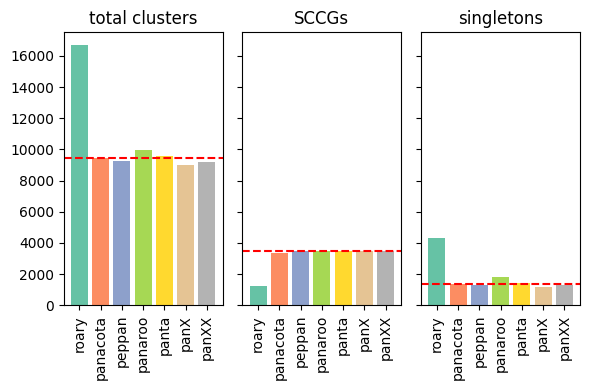

In [15]:
#------------------------------------------#
#          plot general numbers 
#          for SimPan dataset
#------------------------------------------#
dataset="90_50"
c = [colors[method] for method in METHODS]
data = pd.DataFrame()

for method in METHODS:
    if method=="panX" and dataset=="90_80":
        data[method] = [0,0,0]
        continue
    
    df = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")
    sing = len(df[df["singleton"]=="yes"])
    sccg = len(df[df["sccg"]=="yes"])
    total = len(df)
    data[method] = [total,sccg,sing]

data = data.T.rename(columns={0:"total clusters",1:"sccg",2:"singleton"})

df = pd.read_json(f"{ref_path}/{dataset}/{dataset}-reference.json",dtype=False)
sing = len(df[df["singleton"]=="yes"])
sccg = len(df[df["sccg"]=="yes"])
total = len(df)

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,nrows=1,sharex=True,sharey=True,figsize=(6,4))

ax1.bar(data.index,data["total clusters"],color=c)
ax1.set_title("total clusters")
ax1.tick_params(axis="x",labelrotation=90)
ax1.axhline(y=total,color="red",ls="dashed")

ax2.bar(data.index,data["sccg"],color=c)
ax2.set_title("SCCGs")
ax2.tick_params(axis="x",labelrotation=90)
ax2.axhline(y=sccg,color="red",ls="dashed")

ax3.bar(data.index,data["singleton"],color=c)
ax3.set_title("singletons")
ax3.tick_params(axis="x",labelrotation=90)
ax3.axhline(y=sing,color="red",ls="dashed")

fig.tight_layout()
fig.savefig("sim-c-overview.png",dpi=300)
plt.show()


In [16]:
#------------------------------------------#
#       plot Cluster Concordance 
#          for SimPan dataset
#------------------------------------------#
out_df = pd.DataFrame(columns=["dataset","method","concordance"])
locus_hash = {}

for dataset in DATASETS:
    print(f"Working on dataset: {dataset}")
    #build reference
    with open(f"{ref_path}/{dataset}/locus2id.json") as fh:
        locus2id  = json.load(fh)
    ref = pd.read_json(f"{ref_path}/{dataset}/{dataset}-reference.json",dtype=False)[["locus","gene"]].rename(columns={"locus":"tag"})  
    ref = ref.explode("tag")
    ref["locus"] = ref["tag"].apply(get_id,locus2id=locus2id)
    ref.drop(columns="tag",inplace=True)
    ref = ref.groupby(by="gene").agg(list)
    locus_hash["reference"]=set(ref["locus"].apply(get_hash))
    #compare methods
    for method in METHODS:
        if method == "panX" and dataset=="90_80":
            out_df.loc[len(out_df)]=[dataset,method,1]
            continue
        labels = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")
        if method == "peppan":
            #filter out any cluster that contains refound genes
            labels = labels["locus"]
            idx = labels.apply(get_idx)
            labels = labels[~idx]
            locus_hash[method] = set(labels.apply(get_hash))
            c = len(locus_hash["reference"].intersection(locus_hash[method]))/len(locus_hash["reference"])
            out_df.loc[len(out_df)]=[dataset,method,c]
        else:
            locus_hash[method] = set(labels["locus"].apply(get_hash))
            c = len(locus_hash["reference"].intersection(locus_hash[method]))/len(locus_hash["reference"])
            out_df.loc[len(out_df)]=[dataset,method,c]

out_df["1-concordance"]=1-out_df["concordance"]
print("Done!")

Working on dataset: 70_50
Working on dataset: 80_50
Working on dataset: 90_50
Working on dataset: 90_60
Working on dataset: 90_80
Done!


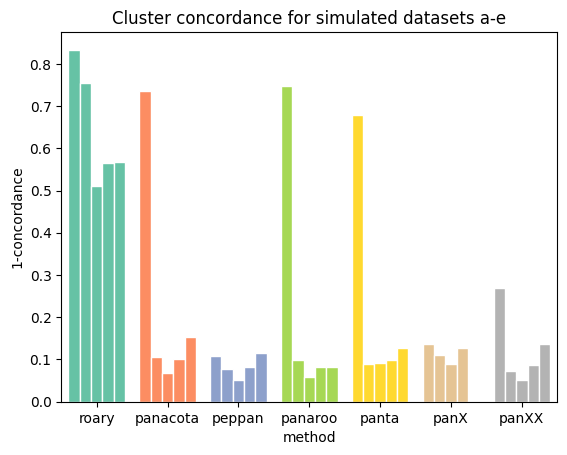

In [17]:
x = METHODS

fig = plt.figure()
ax = plt.subplot(111)

bars = sns.barplot(data=out_df,x="method",y="1-concordance",hue="dataset",width=0.8)

for i,r in enumerate(bars.patches):
    r.set_edgecolor("w")
    r.set_facecolor(colors[METHODS[i%7]])

ax.legend().remove()
ax.set_title("Cluster concordance for simulated datasets a-e")

plt.show()

In [9]:
#------------------------------------------#
#           SCCG Concordance 
#         for SimPan dataset c
#------------------------------------------#
out_df = pd.DataFrame(columns=["dataset","method","count","concordance"])
locus_hash = {}
dataset="90_50"

print(f"Working on dataset: {dataset}")
#build reference
with open(f"{ref_path}/{dataset}/locus2id.json") as fh:
    locus2id  = json.load(fh)
ref = pd.read_json(f"{ref_path}/{dataset}/{dataset}-reference.json",dtype=False)[["locus","gene","count"]].rename(columns={"locus":"tag","count":"size"}) 
ref = ref.explode("tag") 
ref["locus"] = ref["tag"].apply(get_id,locus2id=locus2id)
ref.drop(columns="tag",inplace=True)
ref = ref.groupby(by="gene").agg({"locus":list,"size":"median"}).reset_index()
ref["hashes"] = ref["locus"].apply(get_hash)
groups = ref[["size","hashes"]].groupby("size").agg(set).reset_index()
#compare methods
for method in METHODS:
    print(f"working on {method}")
    for _,g in groups.iterrows():
        if method == "panX" and dataset=="90_80":
            out_df.loc[len(out_df)]=[dataset,method,size,0]
            continue
        size = g["size"]
        ref = g["hashes"]
        
        labels = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")
        if method == "peppan":
            #filter out any cluster that contains refound genes
            labels = labels["locus"]
            idx = labels.apply(get_idx)
            labels = labels[~idx]
            locus_hash[method] = set(labels.apply(get_hash))
            c = len(ref.intersection(locus_hash[method]))/len(ref)
            out_df.loc[len(out_df)]=[dataset,method,size,c]
        else:
            locus_hash[method] = set(labels["locus"].apply(get_hash))
            c = len(ref.intersection(locus_hash[method]))/len(ref)
            out_df.loc[len(out_df)]=[dataset,method,size,c]

print("Done!")

Working on dataset: 90_50
working on roary
working on panacota
working on peppan
working on panaroo
working on panta
working on panX
working on panXX
Done!


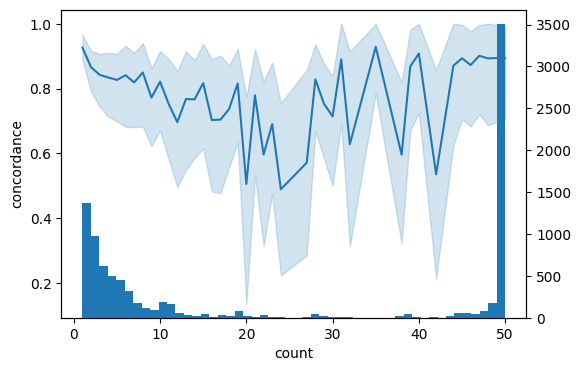

In [23]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
ax2=ax1.twinx()
groups["count"]=groups["hashes"].apply(len)

h = []
for _,g in groups.iterrows():
    for i in range(g["count"]):
        h.append(g["size"])


ax2.hist(h,bins=50)
sns.lineplot(data=out_df,x="count",y="concordance",ax=ax1)

plt.show()